In [100]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

In [3]:
# average(median) price across time with Texas Zipcode (most expensive, least expensive)
# pull out top 10 least expensive zipcode 
# train 15 years of data 
# rmse/mse 
# baseline -> shift 
# from sklearn.model_selection import TimeSeriesSplit

In [4]:
df = pd.read_csv("time-series/zillow_data.csv")

In [15]:
df_texas = df[(df['State'] == 'TX')]
df_texas = df_texas.drop('RegionID', axis = 1)
df_texas

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,95700.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,96100.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,TX,San Angelo,Irion,14373,NaN,NaN,NaN,NaN,...,122500,121800,121600,122200,123500,124700,124300,122600,121600,121600
14472,79313,Anton,TX,Levelland,Hockley,14473,NaN,NaN,NaN,NaN,...,55400,56300,55700,56300,58900,61500,63000,63600,63500,63300
14492,79355,Plains,TX,NaN,Yoakum,14493,NaN,NaN,NaN,NaN,...,100500,100500,101000,100700,99700,97700,95800,94600,94000,93500
14599,79366,Ransom Canyon,TX,Lubbock,Lubbock,14600,134500.0,134500.0,134400.0,134400.0,...,252100,251600,251600,251500,251300,251500,251700,252500,255000,257500


In [85]:
total_plot = df.describe().drop(['RegionName', 'SizeRank', 'RegionID'], axis = 1)
index = total_plot.index
index.name = "Date"
total_plot = total_plot.T
total_plot
texas_plot = df_texas.describe().drop(['RegionName', 'SizeRank'], axis = 1)
index = texas_plot.index
index.name = "Date"
texas_plot = texas_plot.T
#texas_plot
total_plot

Date,count,mean,std,min,25%,50%,75%,max
1996-04,13684.0,118299.123063,86002.509608,11300.0,68800.0,99500.0,143200.0,3676700.0
1996-05,13684.0,118419.044139,86155.673905,11500.0,68900.0,99500.0,143300.0,3704200.0
1996-06,13684.0,118537.423268,86309.226295,11600.0,69100.0,99700.0,143225.0,3729600.0
1996-07,13684.0,118653.069278,86467.945969,11800.0,69200.0,99700.0,143225.0,3754600.0
1996-08,13684.0,118780.254312,86650.941365,11800.0,69375.0,99800.0,143500.0,3781800.0
...,...,...,...,...,...,...,...,...
2017-12,14723.0,281095.320247,367045.388033,14300.0,129900.0,193400.0,313400.0,18307100.0
2018-01,14723.0,282657.060382,369572.741938,14100.0,130600.0,194100.0,315100.0,18365900.0
2018-02,14723.0,284368.688447,371773.905107,13900.0,131050.0,195000.0,316850.0,18530400.0
2018-03,14723.0,286511.376757,372461.234695,13800.0,131950.0,196700.0,318850.0,18337700.0


AttributeError: module 'matplotlib.pyplot' has no attribute 'get_xticks'

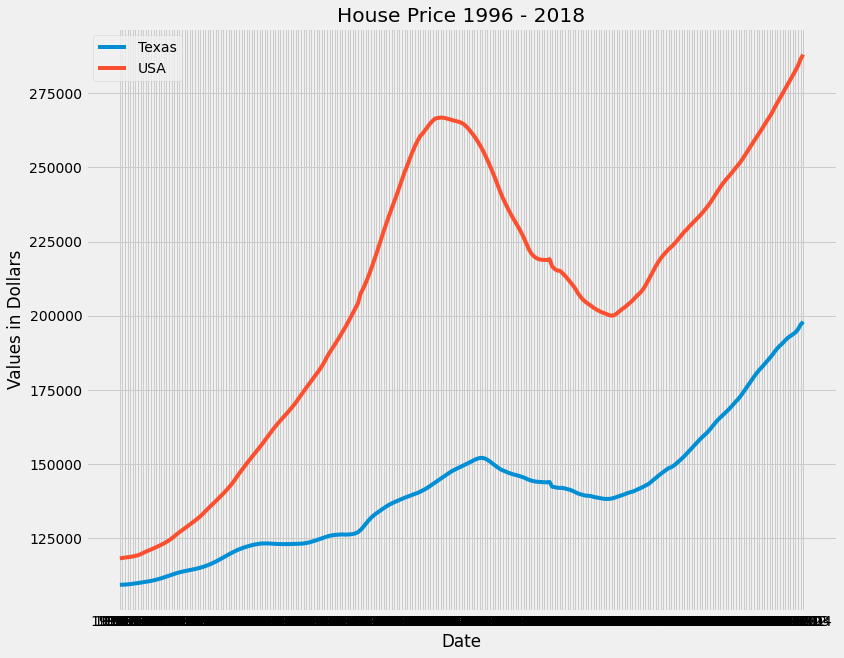

In [110]:
plt.style.use("fivethirtyeight")
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')
date = date.to_series()

# setting figure size to 12, 10
plt.figure(figsize=(12, 10))
 
# Labelling the axes and setting

plt.xlabel("Date")
plt.ylabel("Values in Dollars")
plt.title("House Price 1996 - 2018")


plt.plot(texas_plot["mean"])
plt.plot(total_plot['mean'])
plt.legend(['Texas', 'USA'])
ticks = plt.get_xticks()
plt.xticks([tick for tick in ticks if tick%24 == 0])
#plt.x_axis.set_major_locator(mdates.YearLocator(interval=1))   #to get a tick every 15 minutes
#plt.x_axis.set_major_formatter(mdates.DateFormatter('%Y:%m'))     #optional formatting 

In [97]:
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')
date

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03'],
      dtype='object', length=264)

In [48]:
df2 = pd.read_csv("time-series/zillow_forecast.csv")
df2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,BaseDate,2022-06-30,2022-08-31,2023-05-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,2022-05-31,0.8,2.3,5.1
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2022-05-31,1.0,3.3,5.2
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,2022-05-31,1.0,2.2,4.7
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,2022-05-31,2.2,5.5,10.5
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2022-05-31,0.9,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21131,95186,34430,86343,Zip,AZ,AZ,Crown King,Prescott,Yavapai County,2022-05-31,1.5,3.2,10.3
21132,97088,34430,93009,Zip,CA,CA,Maricopa,Oxnard-Thousand Oaks-Ventura,Ventura County,2022-05-31,3.0,7.6,14.0
21133,98400,34430,95721,Zip,CA,CA,Twin Bridges,Sacramento--Roseville--Arden-Arcade,El Dorado County,2022-05-31,-0.2,3.5,9.9
21134,59376,34430,4109,Zip,ME,ME,Portland,Portland-South Portland,Cumberland County,2022-05-31,1.4,3.9,9.4


In [48]:
date = pd.date_range(start='2014-01', end = '2022-05', freq='M').strftime('%Y-%m')
date
#time_series = pd.Series(ex[date], index=date)

Index(['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', 

Text(0, 0.5, '% increase')

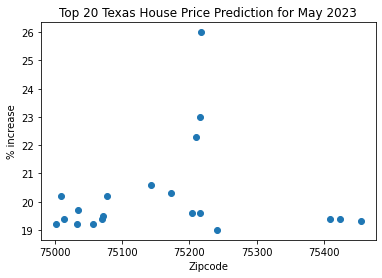

In [49]:
f_predicted = df2.copy()
f_predicted = f_predicted[(df2['State'] == 'TX') & (df2['RegionName'] < 76400)]
#f_fixed['profit'] = (f_fixed['2023-05-31'] - f_fixed['2022-06-30'])/f_fixed['2022-06-30']
f_predicted['growth'] = f_predicted['2023-05-31'] - f_predicted['2022-06-30']
f_predicted = f_predicted.sort_values('growth', ascending=False)
f_predicted = f_predicted.iloc[:20]
f_predicted

fig, ax = plt.subplots()
ax.scatter('RegionName', 'growth', data = f_predicted)
ax.set_title('Top 20 Texas House Price Prediction for May 2023')
ax.set_xlabel('Zipcode')
ax.set_ylabel('% increase')

In [84]:
#f_fixed.drop(columns = f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']].columns[(f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']] > 0).any()])

indexNames = f_fixed[ f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']] > 0 ].index
f_fixed.drop(indexNames , inplace=True)

f_fixed.sort_values(['2022-06-30', '2022-08-31', '2023-05-31'], ascending=True)



,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,BaseDate,2022-06-30,2022-08-31,2023-05-31,growth
